In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from torch.nn import functional as F
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 400
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset.data.transpose((0, 3, 1, 2))  # Change data to (batch-size, channels, height, width)
        self.targets = dataset.targets
        self.data = self.data / 255.0

        self.data = torch.tensor(self.data).float()
        # print((self.data))

    def __getitem__(self, index):
        anchor, anchor_label = self.data[index], self.targets[index]
        positive_indices = [i for i, t in enumerate(self.targets) if t == anchor_label and i != index]
        negative_indices = [i for i, t in enumerate(self.targets) if t != anchor_label]
        positive = self.data[random.choice(positive_indices)]
        negative = self.data[random.choice(negative_indices)]
        return anchor, positive, negative , anchor_label

    def __len__(self):
        return len(self.data)


# Load the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include the 'airplane' and 'automobile' classes
indices = [i for i, label in enumerate(dataset.targets) if label in [0, 1]]  # assuming 'airplane' and 'automobile' are labeled as 0 and 1
dataset.data = dataset.data[indices]
dataset.targets = [dataset.targets[i] for i in indices]

# Create the TripletDataset
triplet_dataset = TripletDataset(dataset)
trainloader = torch.utils.data.DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
test_indices = [i for i, label in enumerate(testset.targets) if label == 0 or label == 1]
testset.targets = [testset.targets[i] for i in test_indices]
testset.data = testset.data[test_indices]

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=0)


100%|██████████| 170498071/170498071 [00:06<00:00, 24601867.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


4
torch.Size([400, 3, 32, 32])


Text(0.5, 1.0, 'negatives')

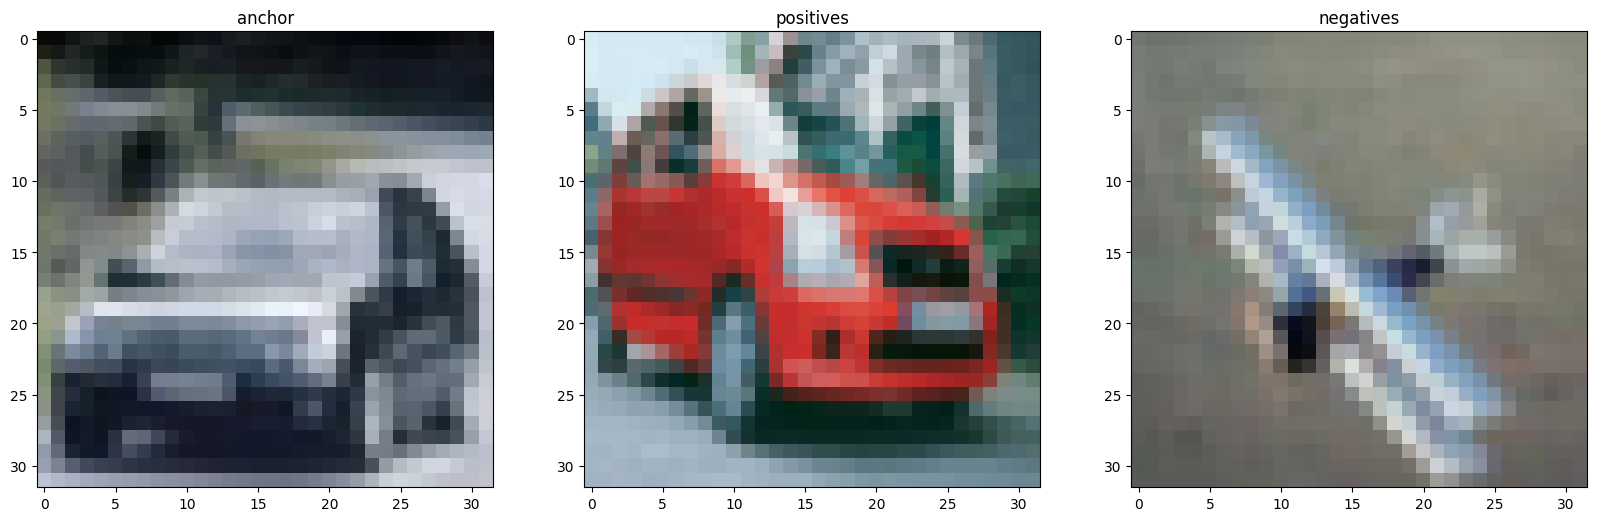

In [4]:
# show three images of first itteration
for i, data in enumerate(trainloader, 0):
    print(len(data))
    anchors, positives, negatives ,_ = data
    print(anchors.shape)
    break
_,axes = plt.subplots( 1,3 , figsize=(20, 10))
i = random.randint(0, batch_size-1)
anchors = anchors.permute(0,2, 3, 1)
axes[0].imshow(anchors[i])
axes[0].set_title(f'anchor')
positives = positives.permute(0,2, 3, 1)
axes[1].imshow(positives[i])
axes[1].set_title('positives')
negatives = negatives.permute(0,2, 3, 1)
axes[2].imshow(negatives[i])
axes[2].set_title('negatives')


In [5]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

In [6]:
model = torchvision.models.resnet50(pretrained=True)

# define a Fc layer with 2 output
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

for param in model.parameters():
    param.requires_grad = True


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [7]:
# define two criterion to calculate the loss function 
criterion_Triple = TripletLoss()
criterion_Cross = torch.nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Train feature extractor

In [9]:
number_of_epoch = 10
loss_values = []
accuracy_values = []
for epoch in (range(number_of_epoch)):   # loop over the dataset multiple times
    running_loss = 0.0
    total = 0
    correct = 0
    for anchors, positives, negatives, labels in tqdm(trainloader, 0):
        # get the inputs; data is a list of [anchors, positives, negatives]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # pass data from the model
        anchor_output = model(anchors)
        positive_output = model(positives)
        negative_output = model(negatives)
        # two loss function
        loss_triple = criterion_Triple(anchor_output, positive_output, negative_output)
        loss_cross = criterion_Cross(anchor_output, labels)

        loss = loss_triple + loss_cross
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()

        # pridiction
        total += anchors.size(0)
        _, predicted = torch.max(anchor_output.data, 1)

        correct += (predicted == labels).sum().item()
     
    loss_values.append(running_loss / total)
    accuracy_values.append(100 * correct / total)

    print(f'ecpoch:{epoch+1}, loss:{running_loss/ total}, accuracy:{100 * correct / total}')

print('Finished Training')

100%|██████████| 25/25 [08:39<00:00, 20.76s/it]


ecpoch:1, loss:0.0001985275138169527, accuracy:99.33


100%|██████████| 25/25 [08:51<00:00, 21.26s/it]


ecpoch:2, loss:8.47240785136819e-05, accuracy:99.76


100%|██████████| 25/25 [08:42<00:00, 20.90s/it]


ecpoch:3, loss:4.7465001698583366e-05, accuracy:99.93


100%|██████████| 25/25 [08:31<00:00, 20.46s/it]


ecpoch:4, loss:2.848333613947034e-05, accuracy:99.96


100%|██████████| 25/25 [08:42<00:00, 20.92s/it]


ecpoch:5, loss:1.8291465379297732e-05, accuracy:99.99


100%|██████████| 25/25 [08:39<00:00, 20.76s/it]


ecpoch:6, loss:1.5203109756112098e-05, accuracy:99.99


100%|██████████| 25/25 [08:33<00:00, 20.56s/it]


ecpoch:7, loss:9.751837933436035e-06, accuracy:100.0


100%|██████████| 25/25 [08:30<00:00, 20.43s/it]


ecpoch:8, loss:1.0133170476183294e-05, accuracy:100.0


100%|██████████| 25/25 [08:35<00:00, 20.63s/it]


ecpoch:9, loss:7.258166931569576e-06, accuracy:99.99


100%|██████████| 25/25 [08:41<00:00, 20.86s/it]

ecpoch:10, loss:7.100004958920181e-06, accuracy:99.99
Finished Training


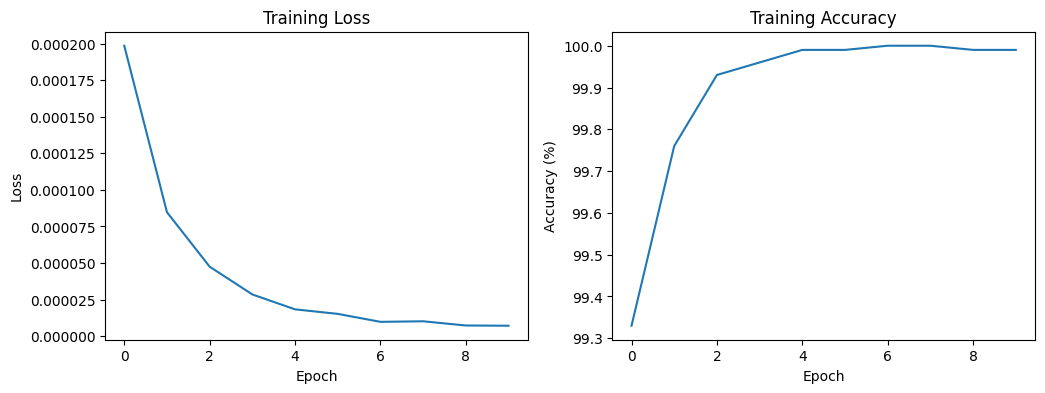

In [10]:
# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

Train fully connected network

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, _,_,labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train dataset:{100 * correct / total}')

Accuracy of the network on the train dataset:99.99


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images ,labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset:{100 * correct / total}')

Accuracy of the network on the test dataset:95.8
